In [73]:
# Using google colab - this first step is for loading in the data from my personal Drive


# Mount my drive
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks'

# Login with google credentials

from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Handle errors from too many requests

import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

# The ID for my personal Drive folder is 1BVUuroPvozFxMjMIYrGOFtI4r6erSBCx
# I am now listing the ID numbers for the files in this folder to find the data files

file_list = drive.ListFile({'q': "'1BVUuroPvozFxMjMIYrGOFtI4r6erSBCx' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

# Train data ID: 1gx8YTvX_nc6y-xlEskJ9EpSHFombL9vC
# Test data ID: 1WrCN8ohhw8b1_V1UfqPiWrN3-eIKyYnh

# Now that I have the ID files, load the pre-cleaned files

data_downloaded = drive.CreateFile({'id': '1Jr7eFwYlRrVqUnIkiAM3mPful4414zOs'})
data_downloaded.GetContentFile('mnist_train.csv')

data_downloaded = drive.CreateFile({'id': '1E3DOSb2GS4afHJ6UWdq-f8vhjAQ-9dO7'})
data_downloaded.GetContentFile('mnist_test.csv')



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
title: MNIST_NB_final.ipynb, id: 1aZoffxlM5L13JNX7hrc1aS1dx7i9G7uk
title: mnist_NBGAuss.ipynb, id: 1WZUFRUH7zQR9YiIcxo8XBXfS6fMAX041
title: mnist_cleaned_test.csv, id: 1E3DOSb2GS4afHJ6UWdq-f8vhjAQ-9dO7
title: mnist_cleaned_train.csv, id: 1Jr7eFwYlRrVqUnIkiAM3mPful4414zOs
title: NB_xor.ipynb, id: 1Q907VbGTX18o-3A_9_ZCOmZjxzVIPsLL
title: Untitled, id: 1tlwHPoX5rMMYokMmvtUfRKOmeDBvAVhp
title: mnist_test.csv, id: 1WrCN8ohhw8b1_V1UfqPiWrN3-eIKyYnh
title: mnist_train.csv, id: 1gx8YTvX_nc6y-xlEskJ9EpSHFombL9vC
title: Copy of NB_xor.ipynb, id: 1aCMp1O_k37FroKYvx-KOANhJgHYOqbSN
title: NaiveBayes.ipynb, id: 1qrSFavxBqSNGq96HBV3Z_lXtP-2pBlRd
title: NB_donnut2.ipynb, id: 1m7c5C714XvSY3ZJNt4AouXcy3wVrEH1s
title: NB_donnut.ipynb, id: 1_kNKQvBXI4b47WpIH58ZesauYHi9Ykj-
title: donnut.csv, id: 1IJv8sUCwIFx9z8qoXq4vijowepTq7Gu3
title: Untitled, id: 1C3rayEvwj0K3NXh11tbjuJqnwc

In [0]:
# Load the data into pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

import io
trainData = pd.read_csv('mnist_train.csv',low_memory=False, lineterminator='\n')

testData = pd.read_csv('mnist_test.csv',low_memory=False, lineterminator='\n')

In [75]:
print(trainData.head(5))
print(trainData.shape)
#testData.head(5)

# Format looks good - 28 x 28 pixel array = 784 features, plus a label column.


   X0  X1  X2  X3  X4  X5  X6  ...  X778  X779  X780  X781  X782  X783  labels
0   0   0   0   0   0   0   0  ...     0     0     0     0     0     0       7
1   0   0   0   0   0   0   0  ...     0     0     0     0     0     0       2
2   0   0   0   0   0   0   0  ...     0     0     0     0     0     0       1
3   0   0   0   0   0   0   0  ...     0     0     0     0     0     0       0
4   0   0   0   0   0   0   0  ...     0     0     0     0     0     0       4

[5 rows x 785 columns]
(10000, 785)


In [0]:
# convert to numpy
np_train = trainData.to_numpy()
np_test = testData.to_numpy()

In [0]:
class GaussNB():

# Epsilon is a hyperparameter - results on the test set were maximized with epsilon between 1100 and 1200.

  def fit(self, x, y, epsilon = float(4000)):

    x = x.astype(float)
    y = y.astype(float)

    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))

    # k represents a number between 0 and 9
    for k in self.K:
      X_k = x[y==k,:]

      mu_k = X_k.mean(axis=0)
      N_k, D = X_k.shape

      self.likelihoods[k] = {
        #Mean 
        "Mean" : X_k.mean(axis=0), 
        # Covariance matrix
        "Cov" : (1/(N_k - 1))*np.matmul((X_k - mu_k).T, (X_k - mu_k)) + epsilon*np.identity(D) # ,80, e = 1e-3     
        }

      self.priors[k] = len(X_k) / len(x)

  def predict(self, x):

    x = x.astype(float)

    N, D = x.shape
    P_hat = np.zeros((N, len(self.K)))

    for k, l in self.likelihoods.items():
      #log(probability) = log(likelihood) + log(prior)
      P_hat[:,k] = mvn.logpdf(x, l["Mean"], l["Cov"]) + np.log(self.priors[k])

    return np.argmax(P_hat, axis=1).astype(float)

def accuracy(y, y_hat):

  return np.mean(y==y_hat)


In [78]:
import numpy as np
print(np_train.shape)
print(np_test.shape)

train_X = np_train[:,:-1]

# Reshape to 1D array
train_y = np_train[:,-1].reshape(len(np_train),)

# Check shape
print(train_X.shape)
print(train_y.shape)

test_X = np_test[:,:-1]
test_y = np_test[:,-1].reshape(len(np_test),)

print(test_X.shape)
print(test_y.shape)

print(train_X[:5])
print(train_y[:5])

(10000, 785)
(60000, 785)
(10000, 784)
(10000,)
(60000, 784)
(60000,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[7 2 1 0 4]


In [79]:
gnb = GaussNB()

gnb.fit(train_X,train_y)

# Train set accuracy
y_hat_train = gnb.predict(train_X)
print("Training set accuracy: " + str(accuracy(train_y,y_hat_train)))


# Test set accuracy
y_hat = gnb.predict(test_X)
print("Test set accuracy: " + str(accuracy(test_y,y_hat)))


Training set accuracy: 0.9842
Test set accuracy: 0.95085


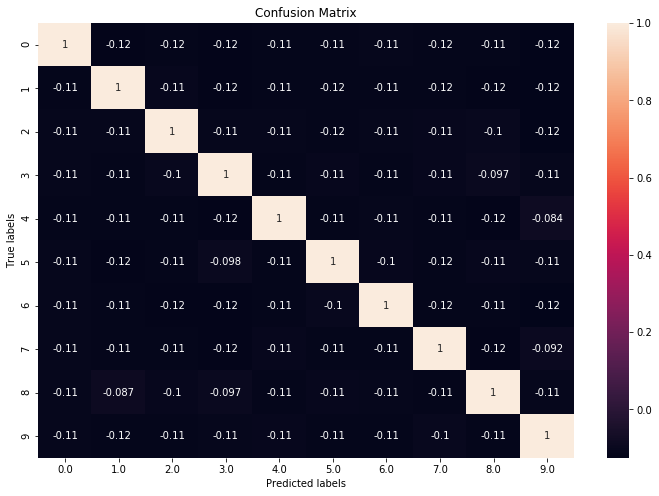

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# create a 2D array representing confusion matrix

arr = pd.crosstab(test_y, y_hat)

#arr = confusion_matrix(test_y,y_hat)

#arr = pd.DataFrame(arr, range(10), range(10))

#normalize this matrix
arr = arr - arr.mean()
arr = arr / arr.max()

#Display as a heatmap

import matplotlib.pyplot as plt     


# labels, title and ticks

fig_dims = (12,8)
fig, ax = plt.subplots(figsize=fig_dims)
sn.heatmap(arr, annot=True, ax=ax,)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

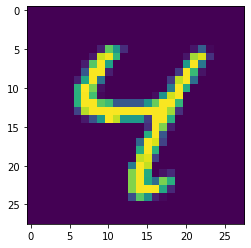

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  22 192 134  32   0   0   0   0   0
    0   0   0  15  77   5   0   0   0   0]
 [  0   0   0   0   0   0   0   0  17 235 250 169   0   0   0   0   0   0
    0   0  15 220 241  37   0   0   0   0]
 [  0   0   0   0   0   0   0  20 189 253 147   0   0   0   0   0   0   0
    0   0 139 253 100   0   0   0   0   0]
 [  0   0   0   0   0   0   0  70 253 253  21   0   0   0   0   

In [87]:
# Produce output of a sample picture

image_1 = train_X[6,:].reshape(28,28) # 7
#print(image_1)

image = np.asarray(image_1).squeeze()
plt.imshow(image)
plt.show()

print(image_1)